# These are some plots where h was a small value = 5 x 10^-15

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [3]:

import matplotlib.pyplot as plt 
from priors import priors_dict
import numpy as np 
import json
import pandas as pd 
import corner
import scienceplots

def load_data(path,variables_to_plot):


    try:
        df_posterior = pd.read_parquet(path)  

    except:
        # Opening JSON file
        f = open(path)
        data = json.load(f)
        f.close()
        #Make it a dataframe. 
        df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    #Make omega into nHz
    df_posterior["omega_gw"] = df_posterior["omega_gw"]*1e9
    df_posterior["h"] = df_posterior["h"]*1e12

    y_post = df_posterior[variables_to_plot].to_numpy()

    # print("Number of samples:",len(df_posterior))
    # print("Truths/Medians/Variances")
    medians = df_posterior[variables_to_plot].median()
    variances = df_posterior[variables_to_plot].var()
    q = [0.00,1.00]
    for i in range(len(medians)):
        print(variables_to_plot[i],medians[i],variances[i])
        print("quantiles:", np.quantile(df_posterior[variables_to_plot[i]],q))
    



    return_code = 0


    extra_median = df_posterior['psi_gw'].median()
    #if extra_median < 1.0: #psi is weird / not converged so don't plot it 
       # print("Ignoring this file since psi not converged",extra_median)
       # return_code = 1
        
    print('-----------------------------***********************----------------------')
    return y_post, return_code







from parse import * 


def drop_braces(string_object):

    string_object = string_object.replace('{', '')
    string_object = string_object.replace('}', '')
    return string_object


def extract_value_from_title(title_string):

    template = '$\\{param_name}$ = ${value}_{lower}^{upper}$'

    parsed_output = parse(template, title_string)

    if parsed_output is None: #Handles h which is not a greek letter
        template = '${param_name}$ = ${value}_{lower}^{upper}$'
        parsed_output = parse(template, title_string)



    

    return parsed_output['param_name'],drop_braces(parsed_output['value']),drop_braces(parsed_output['lower']),drop_braces(parsed_output['upper'])

#https://stackoverflow.com/questions/32923605/is-there-a-way-to-get-the-index-of-the-median-in-python-in-one-command
def argmedian(x):
  return np.argpartition(x, len(x) // 2)[len(x) // 2]

def stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None,logscale=False):




    

    y = []
    fig= None 
    i = 0

    #while i < number_of_files_to_plot:

    for j in range(len(list_of_files)):
        f = list_of_files[j]
        yi,code = load_data(f,variables_to_plot)

        if code == 0:
            y.extend([yi])
            i += 1

        if i > number_of_files_to_plot:
            break
        
        print(i, f)

    plt.style.use('science')

    

    num_params = len(variables_to_plot)
    
    title_values = np.zeros((num_params,number_of_files_to_plot)) #an array with shape number of parameters x number of noise realisations 
    title_upper = np.zeros((num_params,number_of_files_to_plot)) 
    title_lower = np.zeros((num_params,number_of_files_to_plot))

    print("Shape of title value s arary", np.shape(title_values))
    

    for i in range(number_of_files_to_plot): #for each noise realisation 

        k = i 
        if k ==2:
            k = k+1 #convoluted way of skipping C2 color




        if logscale:
            yplot = np.log10(y[i])
            injection_parameters = np.log10(injection_parameters)
            #ranges = np.log10(ranges)
        else:
            yplot = y[i]
        
        print("ranges =", ranges)
        nsamples = len(y[i])
        fs = 20

        new_injection_parameters = [injection_parameters[0]*1e9,injection_parameters[1],injection_parameters[2],injection_parameters[3],injection_parameters[4]]
        



        print("The injection parameters for the plotter are:", new_injection_parameters)
        fig = corner.corner(yplot, 
                            color=f'C{k}',
                            show_titles=True,
                            smooth=True,smooth1d=True,
                            truth_color='C2',
                            quantiles=[0.16, 0.84],
                            truths =new_injection_parameters,
                            range=ranges,
                            labels = labels,
                            label_kwargs=dict(fontsize=fs),
                            axes_scales = axes_scales,
                            weights = np.ones(nsamples)/nsamples,
                            fig=fig)


        kk = 0
        for ax in fig.axes:
            ax_title = ax.get_title()
            
            if ax_title != '':


                #print('2:', ax_title, type(ax_title))
                param_name, value,lower_limit,upper_limit = extract_value_from_title(ax_title) #Get the values that corner.corner sends to the ax title
                #print(parsed_output)

                print(kk,i,param_name,value)
                title_values[kk,i] = value
                title_lower[kk,i] = lower_limit
                title_upper[kk,i] = upper_limit


            
                kk += 1
                


        i += 1


        #Pretty-ify
    for ax in fig.axes:

        if ax.lines: #is anything plotted on this axis?
            
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))

            ax.yaxis.set_tick_params(labelsize=fs-6)
            ax.xaxis.set_tick_params(labelsize=fs-6)


        ax.title.set_size(18)



#     #Get the indices of the median values from the list of medians 
#     idxs = [] #this is the index of the median for each parameter. 
#     for l in range(num_params):
#         idx = argmedian(title_values[l,:])
#         idxs.extend([idx])



#     #Now use it to set the titles
#     kk = 0
#     for ax in fig.axes:
#         ax_title = ax.get_title()
#         if ax_title != '':


#             selected_idx = idxs[kk]

# #foo = f'text$_{{{var}}}$'


#             new_title_string = rf'{labels[kk]} $= {title_values[kk,selected_idx]:.2f}_{{{title_lower[kk,selected_idx]:.2f}}}^{{+{title_upper[kk,selected_idx]:.2f}}}$'
#             print(new_title_string) 
#             ax.set_title(new_title_string, fontsize=18)
#             kk += 1





    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
        

    #return fig            


# Define data files to use

In [8]:
import glob 
list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/pp_plots_h1e-15/*"))
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","delta_gw","alpha_gw"]


def parse_filename(f):
    row = f.split('_')
    omega,phi0,psi,delta,alpha = row[15],row[17],row[19],row[21],row[23] #specific to these filenames
    return float(omega),float(phi0),float(psi),float(delta),float(alpha)


## Plot just one file to check everything ok 

Injection parameters =  (9.900619998201057e-07, 0.6423313768614777, 1.2568043794332358, 0.6514310141220807, 1.0457264372311668)
omega_gw 990.6587211355153 1.8984539313847473
quantiles: [985.47334247 994.77137637]
phi0_gw 0.614779647369087 0.03941430502940785
quantiles: [0.00300911 1.30609062]
psi_gw 1.4207684208930929 0.028891930277956817
quantiles: [0.75660244 2.18035395]
delta_gw 1.0515540947232678 0.009965710080902112
quantiles: [0.75724439 1.34977169]
alpha_gw 0.8924957190986739 0.03410574952146985
quantiles: [0.15623022 1.54613342]
-----------------------------***********************----------------------
1 ../data/nested_sampling/data_for_manuscript/pp_plots_h1e-15/FINAL_pp_plot_h_5e-15_model_earth_seed_1246_omega_9.900619998201057e-07_phi0_0.6423313768614777_psi_1.2568043794332358_delta_0.6514310141220807_alpha_1.0457264372311668_result.json
Shape of title value s arary (5, 1)
ranges = [(891.0557998380951, 1089.0681998021164), (-3.141592653589793, 3.141592653589793), (0.0, 3.141

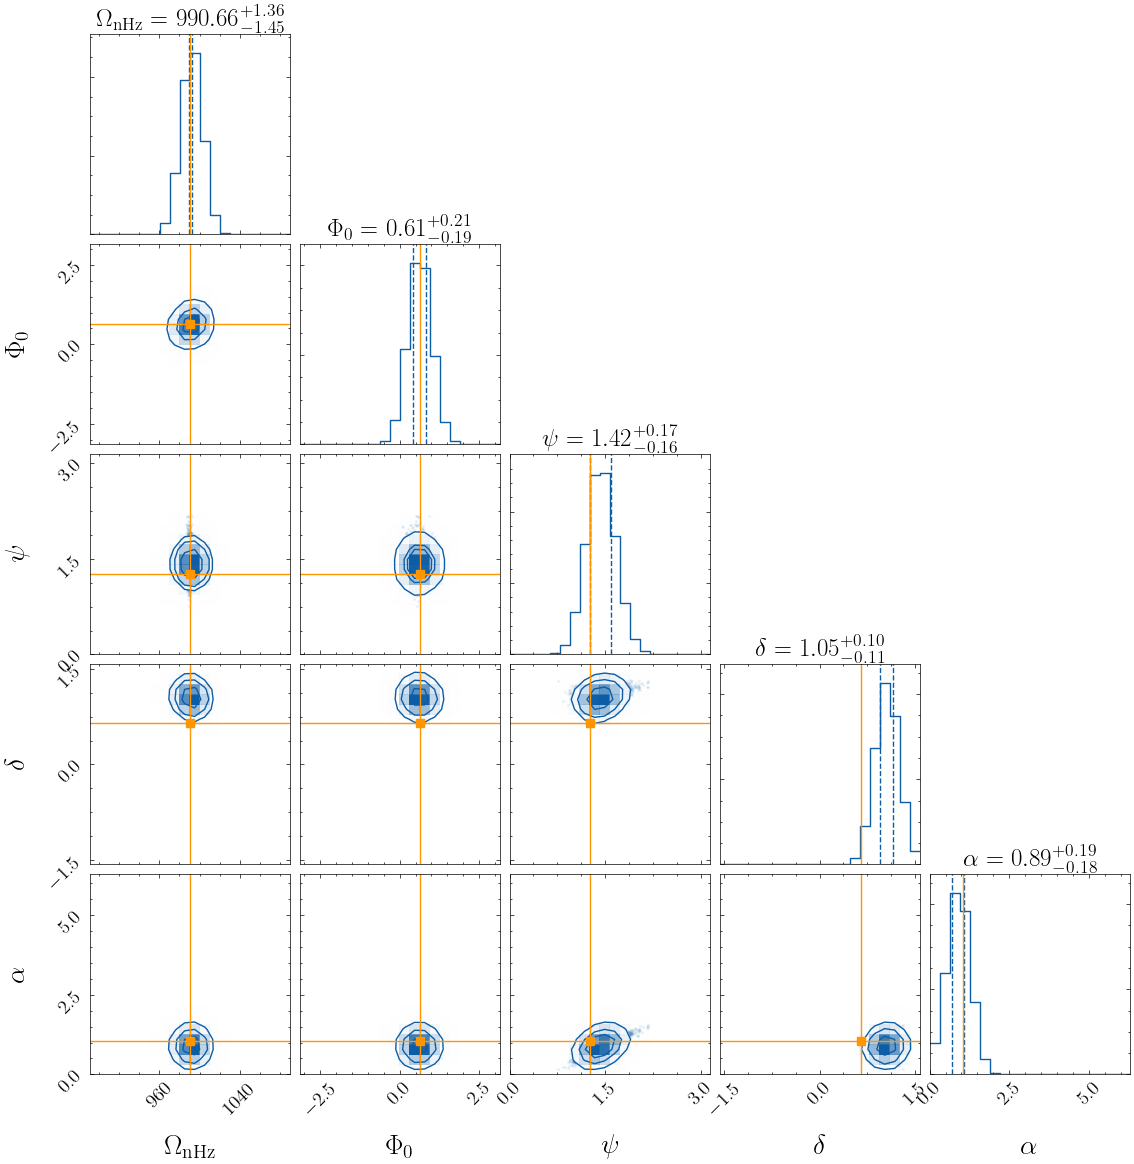

In [7]:
#f = list_of_files[10] #multimodal example
#f = list_of_files[15] 

f = '../data/nested_sampling/data_for_manuscript/pp_plots_h1e-15/FINAL_pp_plot_h_5e-15_model_earth_seed_1246_omega_9.900619998201057e-07_phi0_0.6423313768614777_psi_1.2568043794332358_delta_0.6514310141220807_alpha_1.0457264372311668_result.json'
injection_parameters = parse_filename(f)
ranges=[(injection_parameters[0]*0.9*1e9,injection_parameters[0]*1.1*1e9),(-np.pi,np.pi),(0.0,np.pi),(-np.pi/2,np.pi/2),(0.0,2*np.pi)]

labels = [r'$\Omega_{\rm nHz}$',r'$\Phi_0$',r'$\psi$', r'$\delta$',r'$\alpha$']
axes_scales = None



print("Injection parameters = ", injection_parameters)
number_of_files_to_plot = 1
stacked_corner([f],number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None, logscale=False)


## Now lets look at getting some credible intervals / quantiles 


Follows the calculation in https://git.ligo.org/lscsoft/bilby/-/blob/master/bilby/core/result.py and https://git.ligo.org/lscsoft/bilby/-/blob/master/bilby/core/result.py

In [9]:

def get_injection_credible_level(path):

   
    #Define the parameters 
    parameters = ["omega_gw","phi0_gw","psi_gw","delta_gw","alpha_gw"]

    #Load a file 
    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    #Setup
    weights = np.ones(len(df_posterior))
    injection_parameters = parse_filename(path)

    #Select for that variable
    #parameter = parameters[idx]
    #injection = injection_parameters[idx]


    credible_levels = {parameters[idx]: sum(np.array(df_posterior[parameters[idx]].values <injection_parameters[idx]) * weights) / (sum(weights)) for idx in range(len(parameters))}

    return credible_levels
           




In [10]:
credible_levels = list()
for i in range(len(list_of_files)):
    cc = get_injection_credible_level(list_of_files[i])
    credible_levels.append(cc)



In [12]:
#Make it a df 
credible_levels = pd.DataFrame(credible_levels)
credible_levels

,omega_gw,phi0_gw,psi_gw,delta_gw,alpha_gw
0,0.620563,0.925997,1.000000,0.000000,0.010513
1,0.374037,0.066115,0.070139,0.000115,1.000000
2,0.170890,0.021361,0.554823,0.397114,0.041813
3,0.523298,0.957028,0.295625,0.278152,0.598240
4,0.151784,0.093785,0.972403,0.617568,0.132376
...,...,...,...,...,...
195,0.359315,0.702461,0.885457,0.000000,0.156853
196,0.956692,0.956790,1.000000,1.000000,0.000098
197,0.775783,0.823920,1.000000,1.000000,0.001372
198,0.336404,0.552635,0.149031,0.000000,0.784718


In [13]:
#Save this dataframe since the abve iteration took a bit of time

credible_levels.to_parquet('credible_levels_1e-15')

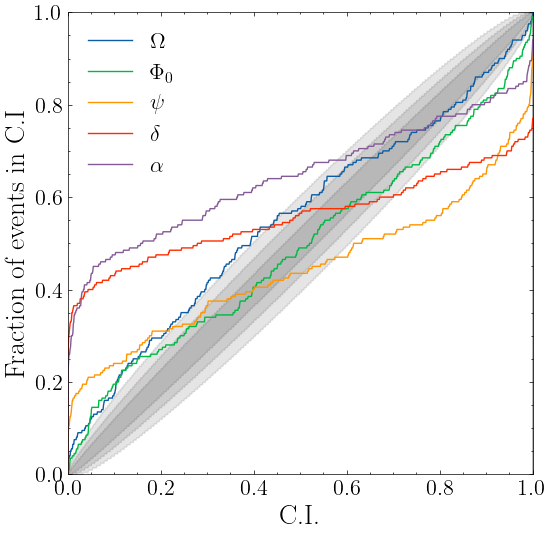

In [15]:

import matplotlib.pyplot as plt 
import scienceplots
import scipy


plt.style.use('science')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)


#Setup
x_values = np.linspace(0, 1, 1001)
N = len(credible_levels)


#Plot the sigma bounds
confidence_interval = [0.68, 0.95, 0.997]
confidence_interval_alpha = 0.1
confidence_interval_alpha = [confidence_interval_alpha] * len(confidence_interval)
for ci, alpha in zip(confidence_interval, confidence_interval_alpha):
    edge_of_bound = (1. - ci) / 2.
    lower = scipy.stats.binom.ppf(1 - edge_of_bound, N, x_values) / N
    upper = scipy.stats.binom.ppf(edge_of_bound, N, x_values) / N
        
    # The binomial point percent function doesn't always return 0 @ 0,
    # so set those bounds explicitly to be sure
    lower[0] = 0
    upper[0] = 0
    ax.fill_between(x_values, lower, upper, alpha=alpha, color='k')


pvalues = []
labels = ['$\Omega$','$\Phi_0$','$\psi$', '$\delta$','$\\alpha$']

for ii, key in enumerate(credible_levels):
    pp = np.array([sum(credible_levels[key].values < xx) /
                       len(credible_levels) for xx in x_values])
    pvalue = scipy.stats.kstest(credible_levels[key], 'uniform').pvalue
    pvalues.append(pvalue)
        
    ax.plot(x_values, pp,label = labels[ii])







fs = 20

#pp = np.array([sum(credible_levels[0].values < xx) /len(credible_levels) for xx in x_values])






#ax.plot(x_values,x_values,c='C2',linestyle = '--')
ax.legend(fontsize=fs-4)
ax.set_xlim(0,1)
ax.set_ylim(0,1)




   
#fs = 20
ax.set_xlabel(r'C.I.', fontsize=fs)
ax.set_ylabel(r'Fraction of events in C.I', fontsize=fs)
ax.xaxis.set_tick_params(labelsize=fs-4)
ax.yaxis.set_tick_params(labelsize=fs-4)





savefig = 'pp_plot_new2'
    # ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    # plt.setp(ax.get_yticklabels()[0], visible=False)   #no 0th label to prevent overlap  
plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)










In [250]:
pvalues

[0.007411540899881184,
 0.015616509561027666,
 5.658070103306277e-05,
 2.3309016429520656e-13,
 9.675428828302317e-09]